## Модули

In [1]:
# Модель
import optuna as opt
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from helpers.data import DataPreprocessor

# Данные
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler

%matplotlib inline

## Загрузка датасетов

In [2]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')

def save_submission(model, subname):
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    preds = model.predict(test_df)
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)

# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
train_df = train_df.drop_duplicates()
test_df = pd.read_csv(TEST_DATASET)

# Сбалансированный (ТОЛЬКО ДЛЯ САБМИТА)
# balanced_df = pd.read_csv(BALANCED_DATASET, index_col=0)
# train_df = balanced_df

# Выравнивание
# first_negatives = train_df[train_df['y'] == 0][:train_df[train_df['y'] == 1]['y'].count()]
# train_df = pd.concat([train_df[train_df['y'] == 1], first_negatives])

# Нормализация всего тренировочного (ТОЛЬКО ДЛЯ САБМИТА)
# train_df = train_df[train_df['Длительность'] < 400]
# train_df = train_df[(train_df['Сумма'] > 2) & (train_df['Сумма'] < 10)]
# train_df = train_df[train_df['До поставки'] < 300]
# train_df = train_df[train_df['Дней между 0_1'] < 400]
# train_df = train_df[train_df['Количество изменений после согласований'] < 2000]
# train_df = train_df[train_df['Количество'] < 300000]

X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Нормализация для кв/тестов
X_train = pd.concat([X_train, y_train], axis=1)

X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

## Препроцессор

In [3]:
# Функция оптимизации
def objective(trial: opt.Trial):
    # Параметры
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    n_estimators = trial.suggest_int('n_estimators', 1300, 3000)
    max_depth = trial.suggest_int('max_depth', 6, 21)
    max_bin = trial.suggest_int('max_bin', 64, 200),
    num_leaves = trial.suggest_int('num_leaves', 32, 260)
    reg_lambda = trial.suggest_float('l2_reg', 0.01, 1)

    # Модель
    data_preprocessor = DataPreprocessor(cat_features, scale_features, drop_features, rename_cols)
    model = LGBMClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,
        reg_lambda=reg_lambda,
        max_bin=max_bin,
        # n_jobs=-1,
        force_col_wise=True
    )

    pipeline = Pipeline([
        ('data_preproc', data_preprocessor),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
    accuracy = cv_score.mean()

    return accuracy

In [ ]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

## Тесты

In [3]:
best_params = {
    'learning_rate': 0.25595401399911066, 
    'n_estimators': 2122, 
    'max_depth': 14, 
    'max_bin': 163, 
    'num_leaves': 176, 
    'reg_lambda': 0.15394653650963538, 
    }

# Модель
data_preprocessor = DataPreprocessor()
model = LGBMClassifier(
    **best_params,
    n_jobs=-1,
    force_col_wise=True,
    # is_unbalance=True,
    objective='binary'
)

pipeline = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model)
])

### Кросс-валидация

In [ ]:
cv_scores = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
print(f'Mean CV: {cv_scores.mean()}')

In [ ]:
cv_scores = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
print(f'Mean CV: {cv_scores.mean()}')

### Валидация

In [4]:
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

[LightGBM] [Info] Number of positive: 28431, number of negative: 169286
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 197717, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143796 -> initscore=-1.784109
[LightGBM] [Info] Start training from score -1.784109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [5]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.903539092853348
0.8882531261841605


In [5]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.9052040960555239
0.8896438044713907


In [11]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.9046608427989249
0.8888588751150328


              precision    recall  f1-score   support

           0    0.96599   0.98090   0.97339     18850
           1    0.87560   0.79560   0.83369      3185

    accuracy                        0.95412     22035
   macro avg    0.92080   0.88825   0.90354     22035
weighted avg    0.95292   0.95412   0.95320     22035



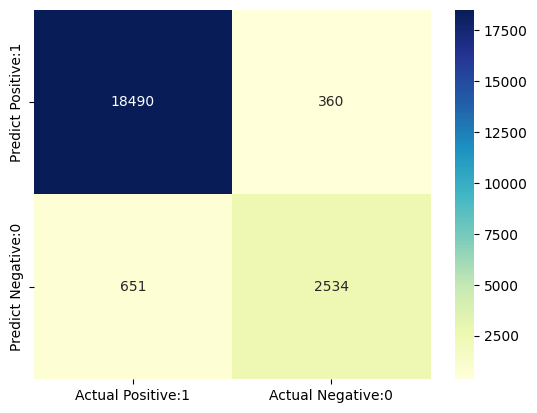

In [6]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],  
                                 index=['Predict Positive:1', 'Predict Negative:0']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds, digits=5))

In [ ]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],  
                                 index=['Predict Positive:1', 'Predict Negative:0']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds, digits=5))

### Важность признаков

In [ ]:
feature_importances = pd.DataFrame({'Feature': pipeline['model'].feature_name_, 'Importance': pipeline['model'].feature_importances_})
feature_importances.to_csv('features.csv', index=False)

## Финальный фит-предикт

In [ ]:
pipeline.fit(X_general, y_general)
save_submission(pipeline, 'submission')